In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd 
import cv2
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet169, DenseNet121
import efficientnet.tfkeras as efn
print('tensorflow version:', tf.__version__)
try:
    print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
          '| device num:', os.environ['CUDA_VISIBLE_DEVICES'])
except:
    pass
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

tensorflow version: 1.14.0
2 Physical GPUs, 2 Logical GPUs


In [2]:
from tensorflow.keras.utils import get_custom_objects
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'
def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))
get_custom_objects().update({'Mish': Mish(mish)})

In [3]:
DATA_PATH = 'C:/data/panda'
MODELS_PATH = 'C:/data/panda/keras_models'
TILES_PATH = 'C:/data/panda/train_images_tiles_q1_256_36'
IMG_SIZE = 256 #224=B0 240=B1 260=B2 300=B3 380=B4 456=B5
SEQ_LEN = 9
BATCH_SIZE = 6
MDL_VERSION = 'v0'
TIFF = 1
RESIZE = None
SEED = 80
print('96x96x16 size:', 96 * 96 * 16)
print('96x96x25 size:', 96 * 96 * 25)
print('128x128x12 size:', 128 * 128 * 12)
print('154x154x10 size:', 154 * 154 * 10)
print('current size:', IMG_SIZE * IMG_SIZE * SEQ_LEN)

96x96x16 size: 147456
96x96x25 size: 230400
128x128x12 size: 196608
154x154x10 size: 237160
current size: 589824


In [4]:
train = pd.read_csv('{}/train.csv'.format(DATA_PATH)).set_index('image_id')
print('train: ', train.shape, '| unique ids:', sum(train['isup_grade'].value_counts()))
files = sorted(set([x[:32] for x in os.listdir(TILES_PATH) if '.ipynb' not in x]))
train = train.loc[files]
train = train.reset_index()
print('train: ', train.shape, '| unique ids:', sum(train['isup_grade'].value_counts()))
train.to_csv('{}/train_dsph.csv'.format(DATA_PATH))

train:  (10616, 3) | unique ids: 10616
train:  (10516, 4) | unique ids: 10516


In [5]:
class DataGenPanda(Sequence):
    def __init__(self, imgs_path, df, batch_size=32, 
                 mode='fit', shuffle=False, aug=None,
                 tiff=-1, resize=None,
                 seq_len=12, img_size=128, n_classes=6):
        self.imgs_path = imgs_path
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.tiff = tiff
        self.resize = resize
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.n_classes = n_classes
        self.side = int(seq_len ** .5)
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        batch_size = min(self.batch_size, len(self.df) - index * self.batch_size)
        X = np.zeros((batch_size, self.side * self.img_size, self.side * self.img_size, 3), dtype=np.float32)
        imgs_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['image_id'].values
        for i, img_name in enumerate(imgs_batch):
            img_patches = self.get_patches(img_name)
            X[i, ] = self.glue_to_one(img_patches)
        if self.mode == 'fit':
            y = np.zeros((self.batch_size, self.n_classes), dtype=np.float32)
            #y = np.zeros(self.batch_size, dtype=np.float32)
            lbls_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['isup_grade'].values
            for i in range(self.batch_size):
                y[i, lbls_batch[i]] = 1
                #y[i, ] = lbls_batch[i]
            return X, y
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('mode parameter error')
    def get_patches(self, img_name):
        seq_imgs = []
        for i in range(self.seq_len):
            img_path = '{}/{}_{}.png'.format(self.imgs_path, img_name, i)
            img = cv2.imread(img_path)
            if not np.any(img):
                print(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.resize:
                img = cv2.resize(img, (int(img.shape[1] / self.resize), int(img.shape[0] / self.resize)))
            img = img.astype(np.float32) / 255
            if self.aug:
                img = self.aug(image=img)['image']
            seq_imgs.append(img)
        return np.array(seq_imgs).astype(np.float32)
    def glue_to_one(self, imgs_seq):
        img_glue = np.zeros((self.img_size * self.side, self.img_size * self.side, 3), dtype=np.float32)
        for i, ptch in enumerate(imgs_seq):
            x = i // self.side
            y = i % self.side
            img_glue[x * self.img_size : (x + 1) * self.img_size, 
                     y * self.img_size : (y + 1) * self.img_size, :] = ptch
        return img_glue

In [6]:
X_train, X_val = train_test_split(train, test_size=.2, stratify=train['isup_grade'], random_state=SEED)
lbl_value_counts = X_train['isup_grade'].value_counts()
class_weights = {i: max(lbl_value_counts) / v for i, v in lbl_value_counts.items()}
class_weights

{0: 1.0,
 1: 1.098470363288719,
 2: 2.14165890027959,
 4: 2.3072289156626504,
 3: 2.3425076452599387,
 5: 2.3641975308641974}

In [7]:
aug = albu.Compose(
    [
        albu.OneOf(
            [
                albu.RandomBrightness(limit=.15), 
                albu.RandomContrast(limit=.3), 
                albu.RandomGamma()
            ], 
            p=.3
        ),
        albu.HorizontalFlip(p=.3),
        albu.VerticalFlip(p=.3),
        albu.ShiftScaleRotate(shift_limit=.2, scale_limit=.2, rotate_limit=30, p=.3)
    ]
)
train_datagen = DataGenPanda(
    imgs_path=TILES_PATH, 
    df=X_train, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=True, 
    aug=aug, 
    tiff=TIFF,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)
val_datagen = DataGenPanda(
    imgs_path=TILES_PATH, 
    df=X_val, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=False, 
    aug=None,
    tiff=TIFF,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)

test X:  (6, 768, 768, 3)
test y:  (6, 6)


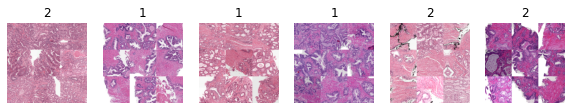

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [8]:
Xt, yt = train_datagen.__getitem__(0)
print('test X: ', Xt.shape)
print('test y: ', yt.shape)
fig, axes = plt.subplots(figsize=(10, 6), ncols=BATCH_SIZE)
for j in range(BATCH_SIZE):
    axes[j].imshow(Xt[j])
    axes[j].axis('off')
    axes[j].set_title(np.argmax(yt[j, ]))
plt.show()
yt

In [9]:
bottleneck = efn.EfficientNetB0(
    input_shape=(int(SEQ_LEN ** .5) * IMG_SIZE, int(SEQ_LEN ** .5) * IMG_SIZE, 3),
    weights='imagenet', 
    include_top=False, 
    pooling='avg'
)
bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
model = Sequential()
model.add(bottleneck)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(.4))
model.add(Dense(512, activation='Mish'))
model.add(BatchNormalization())
model.add(Dropout(.4))
model.add(Dense(128, activation='Mish'))
model.add(BatchNormalization())
model.add(Dropout(.4))
model.add(Dense(6, activation='softmax'))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 24, 24, 1280)      4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [11]:
def qw_kappa_score(y_true, y_pred):
    y_true=tf.math.argmax(y_true, axis=1)
    y_pred=tf.math.argmax(y_pred, axis=1)
    def sklearn_qwk(y_true, y_pred) -> np.float64:
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    return tf.compat.v1.py_func(sklearn_qwk, (y_true, y_pred), tf.double)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-3), # epsilon=1e-4 for float16 numerical stability
    metrics=['categorical_accuracy', qw_kappa_score]
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [12]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_PATH, MDL_VERSION)
if False:
    model = load_model(model_file)
    print('model loaded')
else:
    print('train from scratch')
EPOCHS = 20
earlystopper = EarlyStopping(
    monitor='val_qw_kappa_score', 
    patience=10, 
    verbose=1,
    mode='max'
)
modelsaver = ModelCheckpoint(
    model_file, 
    monitor='val_qw_kappa_score', 
    verbose=1, 
    save_best_only=True,
    mode='max'
)
lrreducer = ReduceLROnPlateau(
    monitor='val_qw_kappa_score',
    factor=.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)
history = model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    class_weight=class_weights,
    callbacks=[earlystopper, modelsaver, lrreducer],
    epochs=EPOCHS,
    verbose=1
)

train from scratch
Epoch 1/20


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[6,144,192,192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Adam/gradients/AddN_197-1-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics/qw_kappa_score/ArgMax_1/_3023]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[6,144,192,192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Adam/gradients/AddN_197-1-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

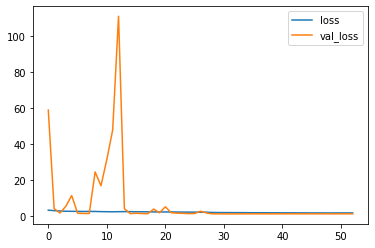

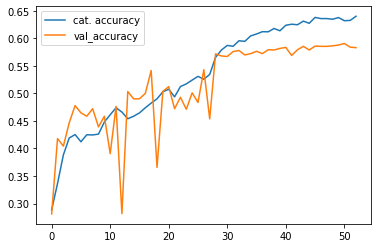

In [12]:
history_file = '{}/history_{}.txt'.format(MODELS_PATH, MDL_VERSION)
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = EPOCHS
plt.plot(history.history['loss'][:ep_max], label='loss')
plt.plot(history.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['categorical_accuracy'][:ep_max], label='cat acc')
plt.plot(history.history['val_categorical_accuracy'][:ep_max], label='val cat acc')
plt.legend()
plt.show()
plt.plot(history.history['qw_kappa_score'][:ep_max], label='qwk')
plt.plot(history.history['val_qw_kappa_score'][:ep_max], label='val qwk')
plt.legend()
plt.show()

In [14]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_PATH, MDL_VERSION)
model = load_model(model_file)
print('model loaded:', model_file)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ValueError: Unknown metric function:kappa_score

In [13]:
%%time
X_score = X_val.copy()
val_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_score, 
    batch_size=1,
    mode='predict', 
    shuffle=False, 
    aug=None,
    tiff=TIFF,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)
preds = model.predict_generator(val_datagen)

CPU times: user 2min, sys: 15.4 s, total: 2min 15s
Wall time: 1min 37s


In [14]:
y_true = X_score['isup_grade'].values
y_pred = np.argmax(preds, axis=1)
print('quadratic cappa score:', cohen_kappa_score(y_true, y_pred, weights='quadratic'))
print('confusion matrix:\n', confusion_matrix(y_true, y_pred))

quadratic cappa score: 0.7295142353917606
confusion matrix:
 [[480  37   6  13  27  16]
 [122 251 109  23  23   5]
 [ 19  59 128  43  14   6]
 [ 20  13  32 107  36  40]
 [ 16  11  18  40 121  44]
 [ 17   0   8  24  46 150]]
